In [1]:
import librosa
import IPython.display as display
from tqdm import tqdm
import numpy as np
from scipy.signal import find_peaks, butter, filtfilt
import os
import soundfile as sf
import matplotlib.pyplot as plt
import librosa.display

In [2]:
def load_wav_files(directory, target_sr=16000):
    wav_files = []
    for root, dirs, files in os.walk(directory):
        with tqdm(total=len(files), desc='Loading files', unit='file') as pbar:
            for file in files:
                if file.endswith(".wav") and file != 'all_channel.wav':
                    file_path = os.path.join(root, file)
                    y, sr = librosa.load(file_path, sr=None)
                    if sr != target_sr:
                        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
                    # remove wav_directory from root
                    path = root.split(os.path.sep)
                    filename = f'{path[1]}_{file}'
                    pbar.set_postfix(file=filename,)
                    wav_files.append((y, filename))
                pbar.update(1)
    return wav_files

In [3]:
def highpass_filter(wav_data, sr, cutoff=100, order=5):
    """
    Apply a high-pass filter to the audio signal to remove low-frequency noise like wind noise.

    :param wav_data: Audio time series and file name tuple
    :param sr: Sample rate
    :param cutoff: Cutoff frequency for the high-pass filter
    :param order: Order of the filter
    :return: Filtered audio time series
    """
    y, file_name = wav_data
    nyquist = 0.5 * sr
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y_filtered = filtfilt(b, a, y)
    return y_filtered, file_name

In [4]:
target_sample_rate = 44100

# 指定存放 WAV 檔案的根目錄
wav_directory = 'train_dataset'
loaded_files = load_wav_files(wav_directory, target_sr=target_sample_rate)
filtered_files = [highpass_filter(y, sr=target_sample_rate, cutoff=220) for y in tqdm(loaded_files, desc='Filtering files', unit='file')]

Loading files: 0file [00:00, ?file/s]
Filtering files: 100%|██████████| 10/10 [00:00<00:00, 124.54file/s]


In [5]:
display.Audio(filtered_files[0][0], rate=target_sample_rate)

In [6]:
def peak_detection(wav, n_fft=None, hop_length=None, height=None, distance=None, prominence=None, width=None, verbose=False):
    
    # 計算短時傅立葉變換 (STFT)
    stft = librosa.stft(wav, n_fft=n_fft, hop_length=hop_length)
    spectrogram = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
    
    # 計算頻譜圖的列均值
    mean_spectrogram = spectrogram.mean(axis=0)
    
    # 使用 scipy.signal.find_peaks 檢測峰值
    peaks, properties = find_peaks(mean_spectrogram, height=height, distance=distance, prominence=prominence, width=width)
    if verbose:
        print(f'Peaks detected: {len(peaks)}')
    return peaks, mean_spectrogram

def plot_peak_detection(wav_file, sr, n_fft=None, hop_length=None, height=None, distance=10, prominence=1, width=None, verbose=False):

    wav, name = wav_file
    
    peaks, mean_spectrogram = peak_detection(wav, n_fft=n_fft, hop_length=hop_length, height=height, distance=distance, prominence=prominence, width=width, verbose=verbose)
    
    times = librosa.frames_to_time(np.arange(len(mean_spectrogram)), sr=sr, hop_length=hop_length)
    
    # 創建圖形
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    # 繪製頻譜圖
    ax1.set_title(f'Mean Spectrogram and detected peaks for {name}')
    ax1.plot(times, mean_spectrogram, alpha=0.8, label='Mean Spectrogram')
    ax1.plot(times[peaks], mean_spectrogram[peaks], "x", label='Peaks')
    ax1.vlines(times[peaks], min(mean_spectrogram), max(mean_spectrogram), color='r', alpha=0.8, linestyle='--')
    ax1.set_ylabel('Amplitude (dB)')
    ax1.legend(loc='upper right')
    
    # 繪製波形圖
    ax2.set_title('Waveform')
    ax2.plot(np.arange(len(wav)) / sr, wav, alpha=0.8, color='gray', label='Waveform')
    ax2.set_ylabel('Amplitude')
    ax2.legend(loc='upper right')
    
    # 顯示圖形
    plt.tight_layout()
    plt.savefig(f'{name}_peaks.png')
    plt.show()



Peaks detected: 11


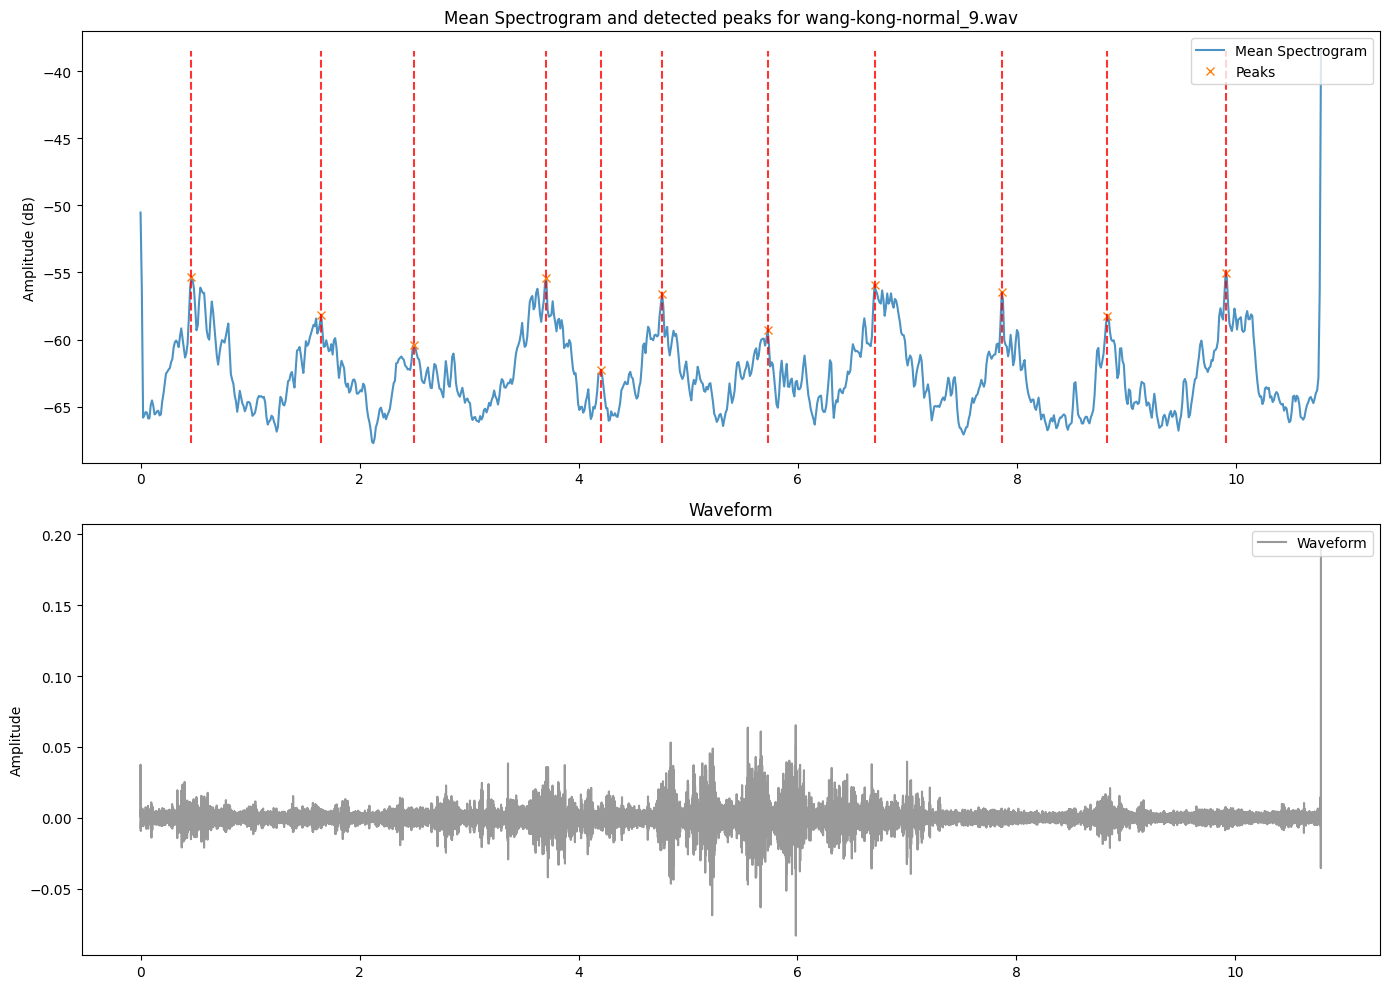

In [7]:
# 呼叫函式並傳遞參數
plot_peak_detection(filtered_files[9], sr=target_sample_rate, n_fft=2048, hop_length=512, height=-64, distance=30, prominence=1, width=5, verbose=True)
display.Audio(filtered_files[9][0], rate=target_sample_rate)

In [8]:
def segment_audio(wav_file, sr=None, segment_length=None, hop_length=None, n_fft=None, height=None, distance=None, prominence=None, width=None, verbose=False):
    """
    Segment audio into clips based on onset detection.

    :param wav_file: Audio time series and file name tuple
    :param sr: Sample rate
    :param segment_length: The desired length of each audio segment in seconds (default: 2)
    :param hop_length: Number of samples between successive frames (default: 512)
    :param n_fft: Length of the FFT window (default: 2048)
    :param height: Required height of peaks (default: None)
    :param distance: Required minimal horizontal distance (in samples) between neighbouring peaks (default: None)
    :param prominence: Required prominence of peaks (default: None)
    :param width: Required width of peaks (default: None)
    :param verbose: Print additional information (default: False)
    :return: A tuple containing a list of audio segments and the sample rate (segments, sr)
    """
    # 載入音訊數據
    y, name = wav_file
    
    peaks, _ = peak_detection(y, n_fft=n_fft, hop_length=hop_length, height=height, distance=distance, prominence=prominence, width=width, verbose=verbose)
    
    # 將峰值位置轉換為時間戳
    peak_times = librosa.frames_to_time(peaks, sr=sr, hop_length=hop_length, n_fft=n_fft)
    
    # 切割音訊,每個片段長度固定為 segment_length 秒
    segments = []
    for peak_time in peak_times:
        # 根據 peak_time 和 segment_length 計算起始和結束時間
        start_time = max(0, peak_time - segment_length / 2)
        end_time = min(peak_time + segment_length / 2, len(y) / sr)
        
        start_sample = int(start_time * sr)
        end_sample = int(end_time * sr)
        segment = y[start_sample:end_sample]
        
        # 如果片段長度不足 segment_length 秒,則補零
        if len(segment) < segment_length * sr:
            padding_length = int(segment_length * sr) - len(segment)
            segment = np.pad(segment, (0, padding_length), mode='constant')
        
        segments.append(segment)
    
    return segments

In [9]:
output_dir = "segmented_audio"
def segment_files_and_save(files, sr, segment_length=None, hop_length=None, n_fft=None, height=None, distance=None, prominence=None, width=None):
    """
    :param files: List of audio time series and file name tuples
    :param sr: Sample rate
    :param segment_length: The desired length of each audio segment in seconds (default: 2)
    :param hop_length: Number of samples between successive frames (default: 512)
    :param n_fft: Length of the FFT window (default: 2048)
    :param height: Required height of peaks (default: None)
    :param distance: Required minimal horizontal distance (in samples) between neighbouring peaks (default: None)
    :param prominence: Required prominence of peaks (default: None)
    :param width: Required width of peaks (default: None)
    :return: A tuple containing a list of audio segments and the sample rate (segments, sr)
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    total_files = len(files)
    with tqdm(total=total_files, desc='Processing files', unit='file') as pbar:
        for i, wav in enumerate(files):
            segments = segment_audio(wav, sr=sr, segment_length=segment_length, hop_length=hop_length, n_fft=n_fft, height=height, distance=distance, prominence=prominence, width=width, verbose=False)
            main_file_name = wav[1].split('.')[0]
            pbar.set_postfix(file=f'{wav[1]}/{total_files}', segments=len(segments))
            for j, segment in enumerate(segments):
                file_name = f'{main_file_name}_segment_{j}.wav'
                sf.write(f'{output_dir}/{file_name}', segment, target_sample_rate)
            pbar.update(1)

In [10]:
n_fft=2048
hop_length=512
height=-64
distance=30
prominence=1
width=5
segment_length=2
segment_files_and_save(files=filtered_files, sr=target_sample_rate, segment_length=segment_length, hop_length=hop_length, n_fft=n_fft, height=height, distance=distance, prominence=prominence, width=width)

Processing files: 100%|██████████| 10/10 [00:00<00:00, 10.96file/s, file=wang-kong-normal_9.wav/10, segments=11]
